# Imports

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils import img_to_array, load_img
import plotly.express as px
import scipy

 image array shape: (224, 224, 3)


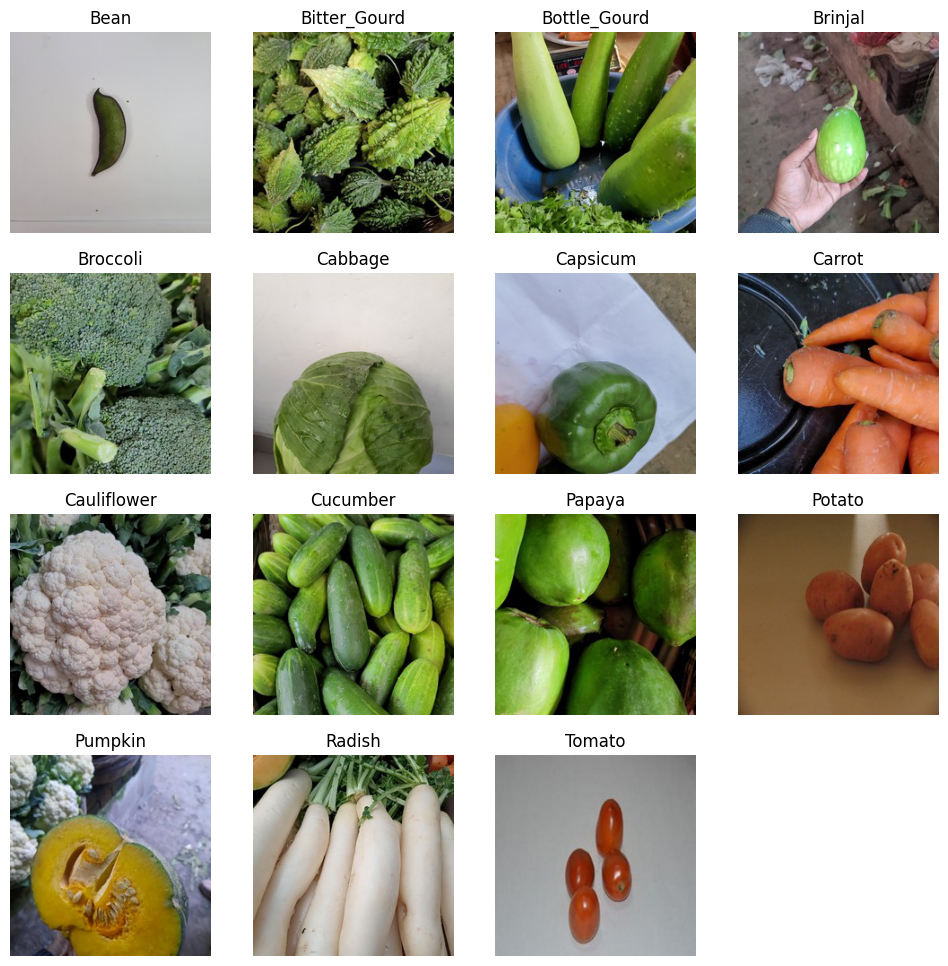

In [2]:
train_path = './Vegetable Images/train'
test_path = './Vegetable Images/test'
validation_path = './Vegetable Images/validation'

image_categories = os.listdir('./Vegetable Images/train')


def plot_images(image_categories):

    plt.figure(figsize=(12,12))
    for i, cat in enumerate(image_categories):
        image_path = train_path + '/' + cat 
        images_in_folder = os.listdir(image_path)
        first_image_in_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_in_folder
        img = load_img(first_image_path)
        img_arr = img_to_array(img)/255.0

        plt.subplot(4,4,i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
    print(f" image array shape: {img_arr.shape}")
    plt.show()

plot_images(image_categories)


# Data Info

In [3]:
class_names = os.listdir(train_path)
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [4]:
n_classes = len(class_names)
number_of_images_byclass = [len(os.listdir(train_path + '/' + name)) for name in class_names]
number_of_images_byclass

[1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

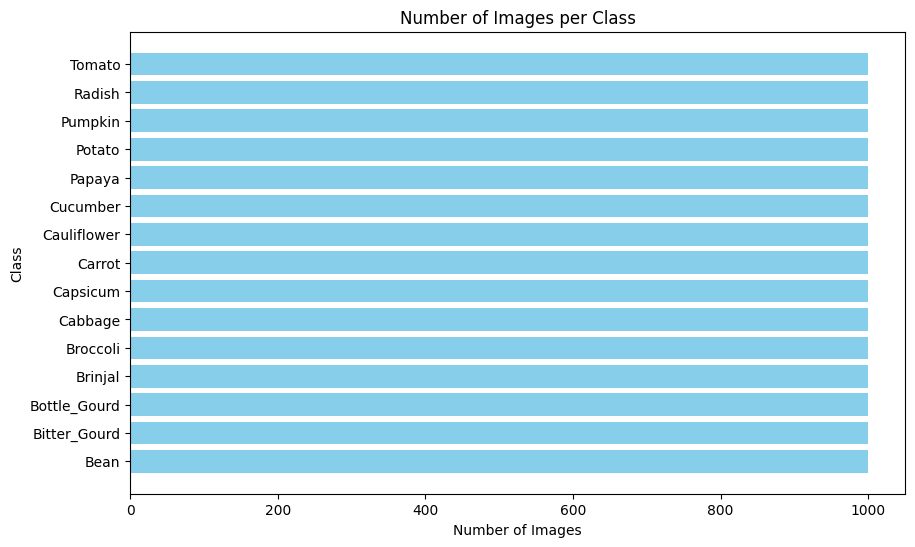

In [5]:
plt.figure(figsize=(10, 6))
plt.barh(class_names, number_of_images_byclass, color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Number of Images per Class') 
plt.show()

In [6]:
fig = px.pie(names=class_names, values=number_of_images_byclass, title="Vegetable Class Distribution")
fig.show()

# Data Loading and Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen = ImageDataGenerator(
    rescale=1/255., 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')
val_image_generator = val_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')
test_image_generator = test_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [8]:
class_map = dict([(v,k) 
                  for k,v 
                  in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC



model = Sequential([
    Conv2D(filters = 16, kernel_size = 3,padding = 'same', strides =1, 
            activation='relu', input_shape=[150,150,3]),
    MaxPooling2D(2),
    Conv2D(filters = 8, kernel_size = 3,padding = 'same', strides =1, 
            activation='relu'),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax'),
])
 
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10952)             0         
                                                                 
 dense (Dense)               (None, 64)                7

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from tensorflow.keras.metrics import AUC
import h5py
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense_convolutional.keras",
                                    save_best_only=True),
        keras.callbacks.EarlyStopping(
        monitor="auc", patience=3)
]


model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[AUC(name="auc", multi_label=True), "accuracy"])


history = model.fit(train_image_generator,
                    epochs=12,
                    validation_data=val_image_generator,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense_convolutional.keras")
print(f"Test AUC: {model.evaluate(test_image_generator)[1]:.2f}")

Epoch 1/12
469/469 [==============================] - 160s 322ms/step - loss: 1.7050 - auc: 0.8773 - accuracy: 0.4267 - val_loss: 1.0622 - val_auc: 0.9567 - val_accuracy: 0.6683
Epoch 2/12
469/469 [==============================] - 91s 195ms/step - loss: 1.1380 - auc: 0.9471 - accuracy: 0.6196 - val_loss: 0.8100 - val_auc: 0.9769 - val_accuracy: 0.7457
Epoch 3/12
469/469 [==============================] - 90s 193ms/step - loss: 0.9925 - auc: 0.9597 - accuracy: 0.6679 - val_loss: 0.7184 - val_auc: 0.9810 - val_accuracy: 0.7873
Epoch 4/12
469/469 [==============================] - 92s 195ms/step - loss: 0.8585 - auc: 0.9691 - accuracy: 0.7152 - val_loss: 0.6276 - val_auc: 0.9845 - val_accuracy: 0.8120
Epoch 5/12
469/469 [==============================] - 92s 195ms/step - loss: 0.8012 - auc: 0.9724 - accuracy: 0.7382 - val_loss: 0.6446 - val_auc: 0.9837 - val_accuracy: 0.7947
Epoch 6/12
469/469 [==============================] - 93s 197ms/step - loss: 0.7622 - auc: 0.9752 - accuracy: 0.74

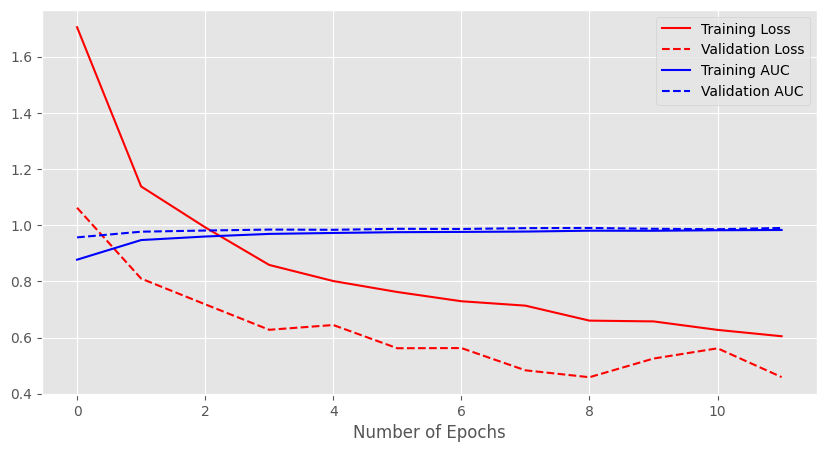

In [12]:
h = history.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['auc'], c='blue', label='Training AUC')
plt.plot(h['val_auc'], c='blue', linestyle='--', label='Validation AUC')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [13]:
model.evaluate(test_image_generator)

94/94 [==============================] - 16s 165ms/step - loss: 0.4668 - auc: 0.9908 - accuracy: 0.8550


[0.46678510308265686, 0.9907779693603516, 0.8550000190734863]

In [14]:
model2 = Sequential([
    Conv2D(filters=5, kernel_size=3, padding='same', strides=1, 
           activation='relu', input_shape=[150,150,3]),
    MaxPooling2D(2),
    Conv2D(filters=2, kernel_size=3, padding='same', strides=1, 
           activation='relu'),
    MaxPooling2D(2),
    
    Flatten(),
    Dense(32, activation='relu'), 
    Dense(15, activation='softmax'),
])
 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 5)       140       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 5)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 2)         92        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 2)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2738)              0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense_convolutional2.keras",
                                    save_best_only=True),
        keras.callbacks.EarlyStopping(
        monitor="auc", patience=3)                                      
]


model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[AUC(name="auc", multi_label=True),"accuracy"])


history = model2.fit(train_image_generator,
                    epochs=12,
                    validation_data=val_image_generator,
                    callbacks=callbacks)

model2 = keras.models.load_model("jena_dense_convolutional2.keras")
print(f"Test AUC: {model2.evaluate(test_image_generator)[1]:.2f}")

Epoch 1/12
469/469 [==============================] - 93s 196ms/step - loss: 1.9383 - auc: 0.8366 - accuracy: 0.3454 - val_loss: 1.5868 - val_auc: 0.9022 - val_accuracy: 0.4667
Epoch 2/12
469/469 [==============================] - 91s 193ms/step - loss: 1.4527 - auc: 0.9107 - accuracy: 0.5031 - val_loss: 1.3806 - val_auc: 0.9229 - val_accuracy: 0.5337
Epoch 3/12
469/469 [==============================] - 91s 194ms/step - loss: 1.3140 - auc: 0.9268 - accuracy: 0.5455 - val_loss: 1.2502 - val_auc: 0.9359 - val_accuracy: 0.5640
Epoch 4/12
469/469 [==============================] - 92s 196ms/step - loss: 1.2531 - auc: 0.9331 - accuracy: 0.5645 - val_loss: 1.2162 - val_auc: 0.9400 - val_accuracy: 0.5917
Epoch 5/12
469/469 [==============================] - 90s 193ms/step - loss: 1.2105 - auc: 0.9378 - accuracy: 0.5821 - val_loss: 1.1469 - val_auc: 0.9453 - val_accuracy: 0.5987
Epoch 6/12
469/469 [==============================] - 92s 196ms/step - loss: 1.1650 - auc: 0.9416 - accuracy: 0.602

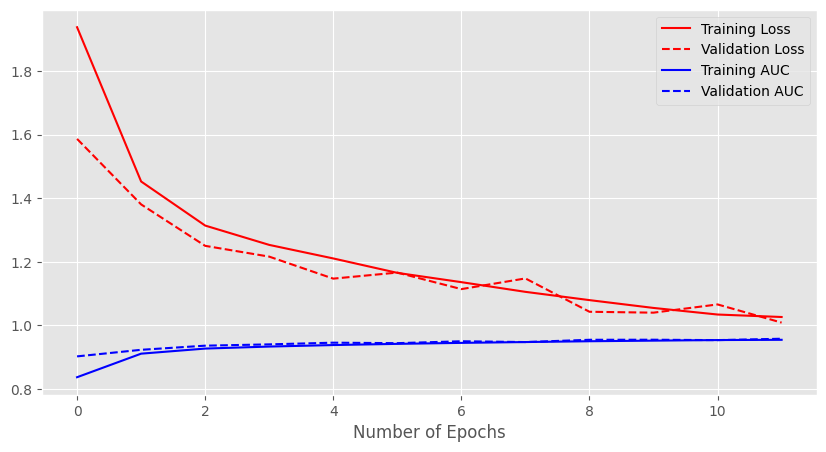

In [16]:
h = history.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['auc'], c='blue', label='Training AUC')
plt.plot(h['val_auc'], c='blue', linestyle='--', label='Validation AUC')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [17]:
model2.evaluate(test_image_generator)

94/94 [==============================] - 15s 164ms/step - loss: 0.9864 - auc: 0.9591 - accuracy: 0.6523


[0.9863949418067932, 0.9591265320777893, 0.6523333191871643]

In [18]:
dense_model = Sequential([
    Flatten(input_shape=(150, 150, 3)),  
    Dense(128, activation='relu'),       
    Dropout(0.2),                     
    Dense(64, activation='relu'),                              
    Dense(15, activation='softmax')      
])

dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               8640128   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 15)                975       
                                                                 
Total params: 8,649,359
Trainable params: 8,649,359
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense_dense_model.keras",
                                    save_best_only=True),
        keras.callbacks.EarlyStopping(
        monitor="auc", patience=3)                                      # zapisanie najlepszego modelu
]


dense_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[AUC(name="auc", multi_label=True),"accuracy"])


history = dense_model.fit(train_image_generator,
                    epochs=12,
                    validation_data=val_image_generator,
                    callbacks=callbacks)

#ładowanie najlepszego modelu
dense_model = keras.models.load_model("jena_dense_dense_model.keras")
print(f"Test AUC: {dense_model.evaluate(test_image_generator)[1]:.2f}")

Epoch 1/12
469/469 [==============================] - 93s 196ms/step - loss: 3.2665 - auc: 0.5025 - accuracy: 0.0662 - val_loss: 2.7081 - val_auc: 0.5000 - val_accuracy: 0.0667
Epoch 2/12
469/469 [==============================] - 92s 195ms/step - loss: 2.7121 - auc: 0.4997 - accuracy: 0.0620 - val_loss: 2.7081 - val_auc: 0.5000 - val_accuracy: 0.0667
Epoch 3/12
469/469 [==============================] - 92s 195ms/step - loss: 2.7083 - auc: 0.4996 - accuracy: 0.0641 - val_loss: 2.7081 - val_auc: 0.5000 - val_accuracy: 0.0667
Epoch 4/12
94/94 [==============================] - 15s 158ms/step - loss: 2.7081 - auc: 0.5000 - accuracy: 0.0667
Test AUC: 0.50


1/1 [==============================] - 0s 203ms/step


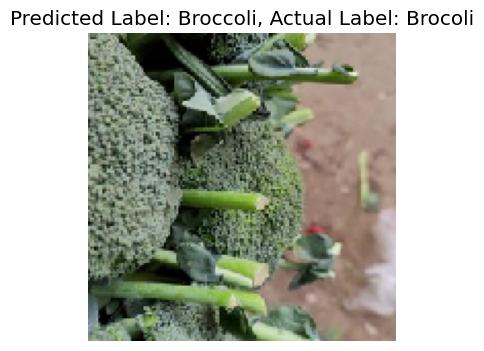

In [20]:
from tensorflow.keras.preprocessing import image

test_image_path = 'Vegetable Images/test/Broccoli/1011.jpg'

def generate_predictions(test_image_path, actual_label):
    
    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

generate_predictions(test_image_path, actual_label='Brocoli')

1/1 [==============================] - 0s 18ms/step


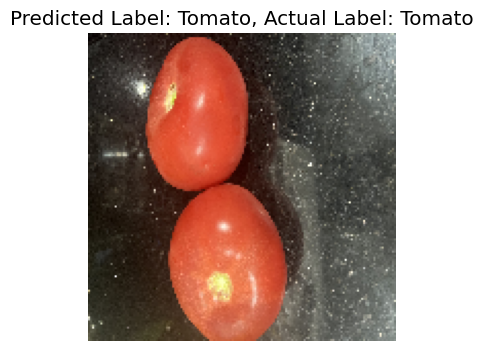

In [21]:
external_image_path_1 = "tomato.jpg"
generate_predictions(external_image_path_1, actual_label='Tomato')